# Day 25- Beginner Data Science Project

## Predict Housing Prices using a selection of features in the [Centadata set](http://centadata.publicdata.hk)

### The Data Science Process:
1. Perform Exploratory data analysis
2. Cleanup and replace missing values or drop columns as required.
3. Predict the target variable.
4. Evaluate the accuracy of the model
5. Perform Cross validation of your model and tabulate results.
6. Can you improve the model performance? if yes, how? 
7. Apply more than one possible algorithm on the data to compare and evaluate performance?
8. Recommend the best algorithm given the dataset and its features.
9. Prepare a presentation for each of your findings and recommendation.

## I. Getting Data, Data Wrangling, and Exploratory Data Analysis

## Preliminary

In [1]:
import requests, json # for getting data
from urllib.parse import urlencode

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

#### let's get data

In [20]:
base_url = 'https://centadata.publicdata.hk/centadata-54990be.json'
params = {
    "sql": "select * from centadataall where txdate > '2017-01-01'"
}
url_params = urlencode( params )
target_url = base_url + "?" + url_params

data = requests.get( base_url, params )

if data.status_code == 200:
    cdata = json.loads( data.text )
    raw = pd.DataFrame(data = cdata['rows'],
                     columns = cdata['columns']
                     )
else:
    print(f"Can't download data with error code:{data.status_code} for {target_url}")

In [21]:
raw.dtypes

unitcode                      object
txdate                        object
price                          int64
buildingcode                  object
saleablearea                 float64
grossarea                    float64
xaxis                         object
yaxis                         object
buildingname                  object
phasecode                     object
phasename                     object
estatecode                    object
estatename                    object
buildingaddress               object
dateofcompletion              object
numberofunits                  int64
numberoffloors                 int64
flatsperfloor                  int64
schoolnet                     object
buildingnamechinese           object
phasenamechinese              object
estatenamechinese             object
buildingaddresschinese        object
region                        object
regionchinese                 object
regioncode                     int64
propertydeveloperchinese      object
p

#### Let's drop some obviously unneccessary columns

... and some not so obvious:
1. _Building Name_, _Phase Name_, _Estate Name_: the name basically describle the same dimension of information as the address and region does
2. _xaxis_: too building specific
* _property developer_ & _property manager_: this probably has some impact on the value but encoding this could be a challenge

and **building address**, is a higher dimenion of the `schoolnet` and `region` data that is potentially very important. **A useful thing to do is actually to run an unsupervised ML model on the address with prices to discover different pockets in Hong Kong.** This can be visually represented further on a map. The _pockets_ or clusters can be passed further back into the regression model as a feature to help improve the model's predictability.

In [59]:
l_col_to_drop = [
    'unitcode', 'buildingcode', 'buildingname',
    'xaxis',
    #'buildingaddress',
    'phasecode', 'phasename',
    'estatecode', 'estatename',
    'buildingnamechinese', 'phasenamechinese', 'estatenamechinese', 'buildingaddresschinese', 'regionchinese',
    'regioncode',
    'propertydeveloperchinese','propertyfacilitieschinese','propertymanagerchinese'
]
df = raw.drop( columns = l_col_to_drop )

#### Let's write this to a CSV to reduce download time

In [ ]:
fname = 'data/centadata_df.csv'
uinput = input('Write [w], or Load [l]:').upper()

if uinput == 'L':
    df = pd.read_csv(fname)
    print( f'data file {fname} loaded into dataframe: df')
elif input == 'W':
    df.to_csv(fname)
    print(f'data written to {fname}')
else:
    print(f'Invalid input: {uinput}; Nothing done.')

In [3]:
df.head()

,Unnamed: 0,txdate,price,saleablearea,grossarea,yaxis,buildingaddress,dateofcompletion,numberofunits,numberoffloors,flatsperfloor,schoolnet,region
0,0,2017-02-16,2880000,392.0,NaN,2/F,205A TUNG CHOI STREET,1963-08-01,8,8,1,九龍區32號校網,Mongkok/Yaumatei
1,1,2018-01-11,3000000,392.0,NaN,3/F,205A TUNG CHOI STREET,1963-08-01,8,8,1,九龍區32號校網,Mongkok/Yaumatei
2,2,2017-06-26,51000000,1912.0,2500.0,5/F,4A-4B WONG NAI CHUNG GAP ROAD,1965-09-01,8,8,1,香港區12號校網,Happy Valley/Mid Level East
3,3,2018-03-21,4150000,294.0,487.0,16/F,98 TSEUK LUK STREET,1999-01-01,30,15,2,九龍區43號校網,Diamond Hill/Wong Tai Sin
4,4,2017-11-28,5250000,530.0,NaN,8/F,54-58 SOUTH WALL ROAD,1969-10-01,32,9,4,九龍區41號校網,Diamond Hill/Wong Tai Sin


### Missing Data

Text(176,0.5,'missing data')

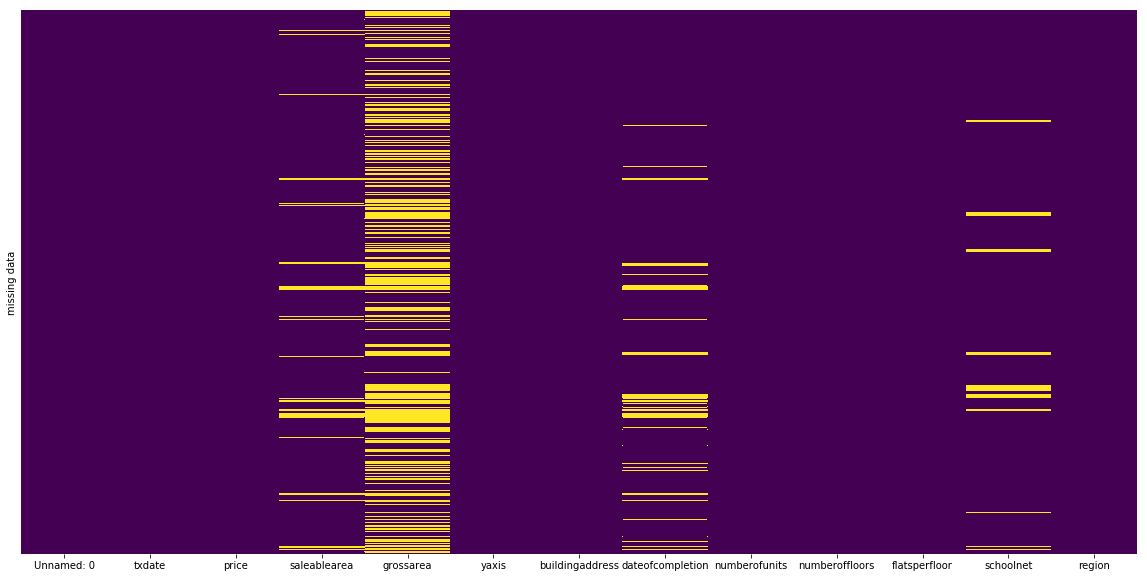

In [17]:
plt.figure(figsize = (20,10))
sns.heatmap(df.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')
plt.ylabel('missing data')

#### Drop Missing
we expect that `grossarea` has a very similar effect as `saleablearea`, and because so many transaction is missing it; it might be smart to drop it.

In [19]:
df_new = df.drop( columns = 'grossarea').dropna()
print( f'original df shape: {df.shape}')
print( f'without missing data: {df_new.shape}')

original df shape: (100700, 13)
without missing data: (87759, 12)


### Data Cleaning & Feature Engineering
* `price`: transform into price per square foot, `price_per_sqf` for ease of comparison
* `yaxis`: into `floor_number` and `is_dettached`
* `dateofcompletion`: into `building_age`
* `txdate`: into `deal_age`, `deal_year`
* `schoolnet`: translate from Chinese into `schoolnet_en`

Create a `price_per_sqf` column

In [77]:
df_new['price_per_sqf'] = df_new['price']/ df_new['saleablearea']

In [48]:
import re

def get_floor_num(x):
    m = re.search(r'(\d+|G{1})/F', x)
    num = np.nan  # set to 0 by default; lots of whole buildings
    if m is None:
        if x == 'L/G':
            num = -1
        elif x == 'U/G':
            num = -2
    else:
        num = m.group(1)
        if num == 'G':
            num = 0
    return num

df_new['floor_number'] = df_new['yaxis'].apply( get_floor_num )
df_new['is_dettached'] = df_new['floor_number'].apply( lambda x: 1 if pd.isnull(x) else 0)
df_new['floor_number'] = df_new['floor_number'].fillna(0)

In [50]:
from datetime import datetime
today = datetime.today()

df_new['dateofcompletion'] = df_new['dateofcompletion'].astype('datetime64[ns]')
df_new['txdate'] = df_new['txdate'].astype('datetime64[ns]')

df_new['building_age'] = df_new['dateofcompletion'].apply(lambda x: (today - x).days)
df_new['deal_age'] = df_new['txdate'].apply(lambda x: (today - x).days)
df_new['deal_year'] = df_new['txdate'].apply(lambda x: x.year)

translating `schoolnet` using [Yandex Translate API](https://tech.yandex.com/translate/doc/dg/reference/translate-docpage/)

In [51]:
y_api_key = 'trnsl.1.1.20181114T024427Z.ff404c0045841b1a.7149dd078b7c5251bff61e0e0cc194a6ea5aade4'
base_url = 'https://translate.yandex.net/api/v1.5/tr.json/translate'

l_schoolnet = list( df_new['schoolnet'].unique())
params = {
    'key': y_api_key,
    'lang': 'zh-en',
    'text': l_schoolnet
}
url_params = urlencode( params )
target_url = base_url + "?" + url_params

data = requests.get( base_url, params )

if data.status_code == 200:
    data_json = json.loads( data.text )
    l_schoolnet_en = list(data_json['text'])
    
    schoolnet_dict = {
        zh : en for zh, en in zip( l_schoolnet, l_schoolnet_en)
    }
    
    df_new['schoolnet_en'] = df_new['schoolnet'].apply( lambda x: schoolnet_dict[x])
    print(f'Translated {len(l_schoolnet_en)} school net names and created new column "schoolnet_en"')
else:
    print(f"Can't download data with error code:{data.status_code} for {target_url}")

Translated 35 school net names and created new column "schoolnet_en"


In [62]:
l_int = [
        'numberofunits', 'numberoffloors', 'flatsperfloor', 'floor_number', 
      'building_age', 'deal_age', 'deal_year','is_dettached'
]

df_new[ l_int ] = df_new[ l_int ].astype('int64')

In [79]:
df_new.head()

,Unnamed: 0,txdate,price,saleablearea,yaxis,buildingaddress,dateofcompletion,numberofunits,numberoffloors,flatsperfloor,schoolnet,region,floor_number,building_age,deal_age,deal_year,schoolnet_en,norm_price,is_dettached,price_per_sqf
0,0,2017-02-16,2880000,392.0,2/F,205A TUNG CHOI STREET,1963-08-01,8,8,1,九龍區32號校網,Mongkok/Yaumatei,2,20194,636,2017,Kowloon district No. 32 school network,-0.519269,0,7346.938776
1,1,2018-01-11,3000000,392.0,3/F,205A TUNG CHOI STREET,1963-08-01,8,8,1,九龍區32號校網,Mongkok/Yaumatei,3,20194,307,2018,Kowloon district No. 32 school network,-0.524245,0,7653.061224
2,2,2017-06-26,51000000,1912.0,5/F,4A-4B WONG NAI CHUNG GAP ROAD,1965-09-01,8,8,1,香港區12號校網,Happy Valley/Mid Level East,5,19432,506,2017,Hong Kong District No. 12 school network,3.989462,0,26673.640167
3,3,2018-03-21,4150000,294.0,16/F,98 TSEUK LUK STREET,1999-01-01,30,15,2,九龍區43號校網,Diamond Hill/Wong Tai Sin,16,7257,238,2018,Kowloon district No. 43 school network,-0.428758,0,14115.646259
4,4,2017-11-28,5250000,530.0,8/F,54-58 SOUTH WALL ROAD,1969-10-01,32,9,4,九龍區41號校網,Diamond Hill/Wong Tai Sin,8,17941,351,2017,Kowloon district No. 41 school network,-0.297205,0,9905.660377


#### Let's save the cleaned data for use later

In [63]:
fname = 'data/centadata_clean.csv'
df_new.to_csv(fname)

#### Normalize Prices
we are normalizing house price by year but there might be a smarter way, like getting Housing Price Index which the HK government does publish

In [53]:
df_pindex = df_new.groupby('deal_year')['price'].agg({'mean_price': 'mean', 'price_std': 'std'})
df_pindex

/Users/JHO/.virtualenvs/accelerateHK3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


,mean_price,price_std
deal_year,,
2017,8.421960e+06,1.067263e+07
2018,9.313742e+06,1.204349e+07


In [54]:
def norm_price( row ):
    deal_year = row['deal_year']
    pmean = df_pindex[df_pindex.index == deal_year]['mean_price']
    pstd = df_pindex[df_pindex.index == deal_year]['price_std']
    nprice = (row['price'] - pmean )/ pstd
    return float(nprice.values)

df_new['norm_price'] = df_new.apply( norm_price, axis = 1)
df_new.head()

,Unnamed: 0,txdate,price,saleablearea,yaxis,buildingaddress,dateofcompletion,numberofunits,numberoffloors,flatsperfloor,schoolnet,region,floor_number,building_age,deal_age,deal_year,schoolnet_en,norm_price,is_dettached
0,0,2017-02-16,2880000,392.0,2/F,205A TUNG CHOI STREET,1963-08-01,8,8,1,九龍區32號校網,Mongkok/Yaumatei,2,20194,636,2017,Kowloon district No. 32 school network,-0.519269,0
1,1,2018-01-11,3000000,392.0,3/F,205A TUNG CHOI STREET,1963-08-01,8,8,1,九龍區32號校網,Mongkok/Yaumatei,3,20194,307,2018,Kowloon district No. 32 school network,-0.524245,0
2,2,2017-06-26,51000000,1912.0,5/F,4A-4B WONG NAI CHUNG GAP ROAD,1965-09-01,8,8,1,香港區12號校網,Happy Valley/Mid Level East,5,19432,506,2017,Hong Kong District No. 12 school network,3.989462,0
3,3,2018-03-21,4150000,294.0,16/F,98 TSEUK LUK STREET,1999-01-01,30,15,2,九龍區43號校網,Diamond Hill/Wong Tai Sin,16,7257,238,2018,Kowloon district No. 43 school network,-0.428758,0
4,4,2017-11-28,5250000,530.0,8/F,54-58 SOUTH WALL ROAD,1969-10-01,32,9,4,九龍區41號校網,Diamond Hill/Wong Tai Sin,8,17941,351,2017,Kowloon district No. 41 school network,-0.297205,0


### Exploratory Data Analysis

/Users/JHO/.virtualenvs/accelerateHK3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


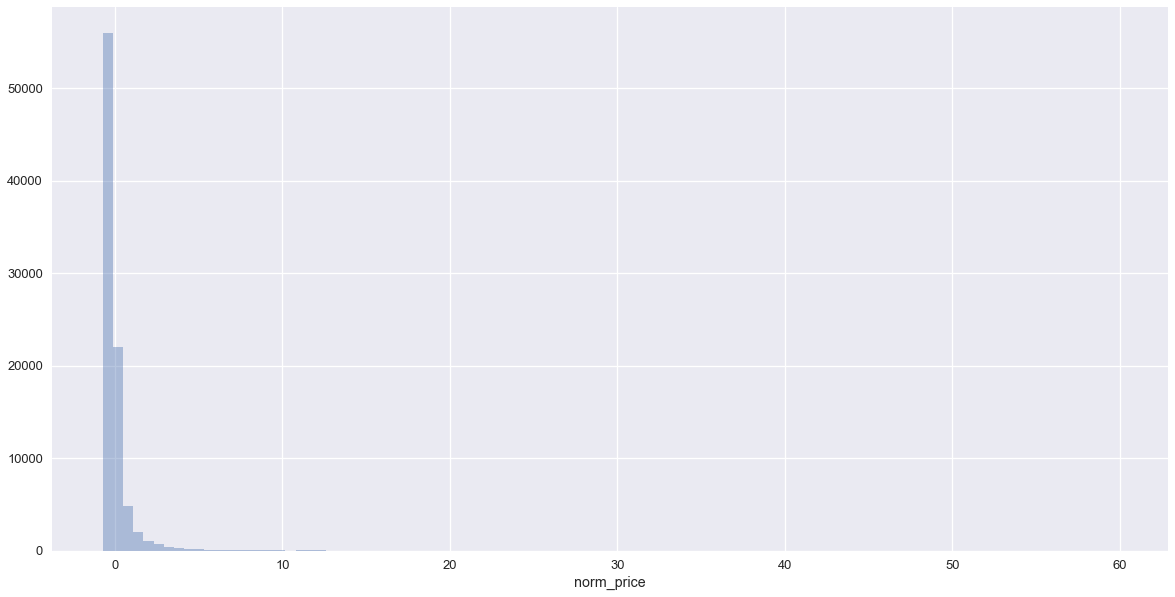

In [55]:
plt.figure(figsize = (20,10))
sns.set(style = 'darkgrid', context = 'talk')
sns.distplot(df_new['norm_price'], kde = False, bins = 100)


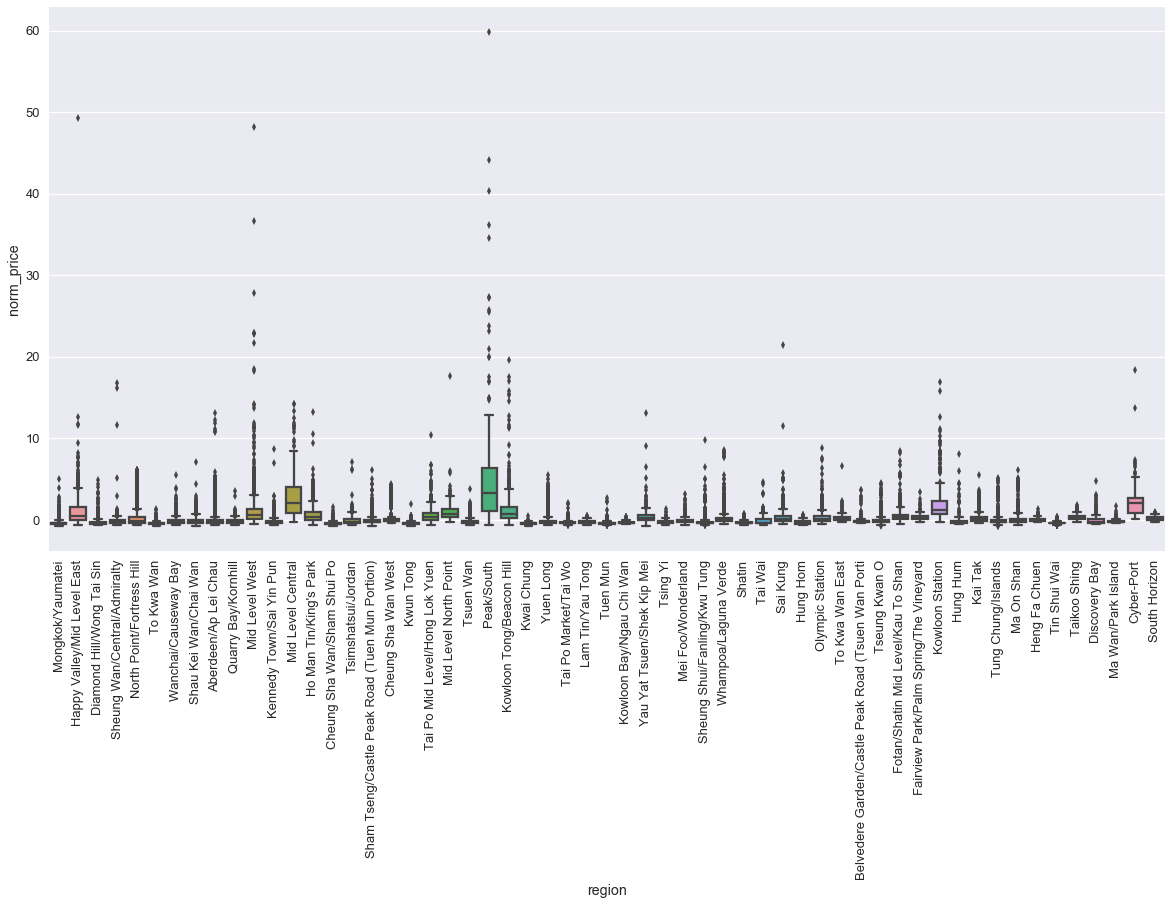

In [56]:
plt.figure(figsize = (20,10))
sns.set(style = 'darkgrid', context = 'talk')
bplot = sns.boxplot(y ='norm_price', x = 'region', data = df_new)
for label in bplot.get_xticklabels():
    label.set_rotation(90)

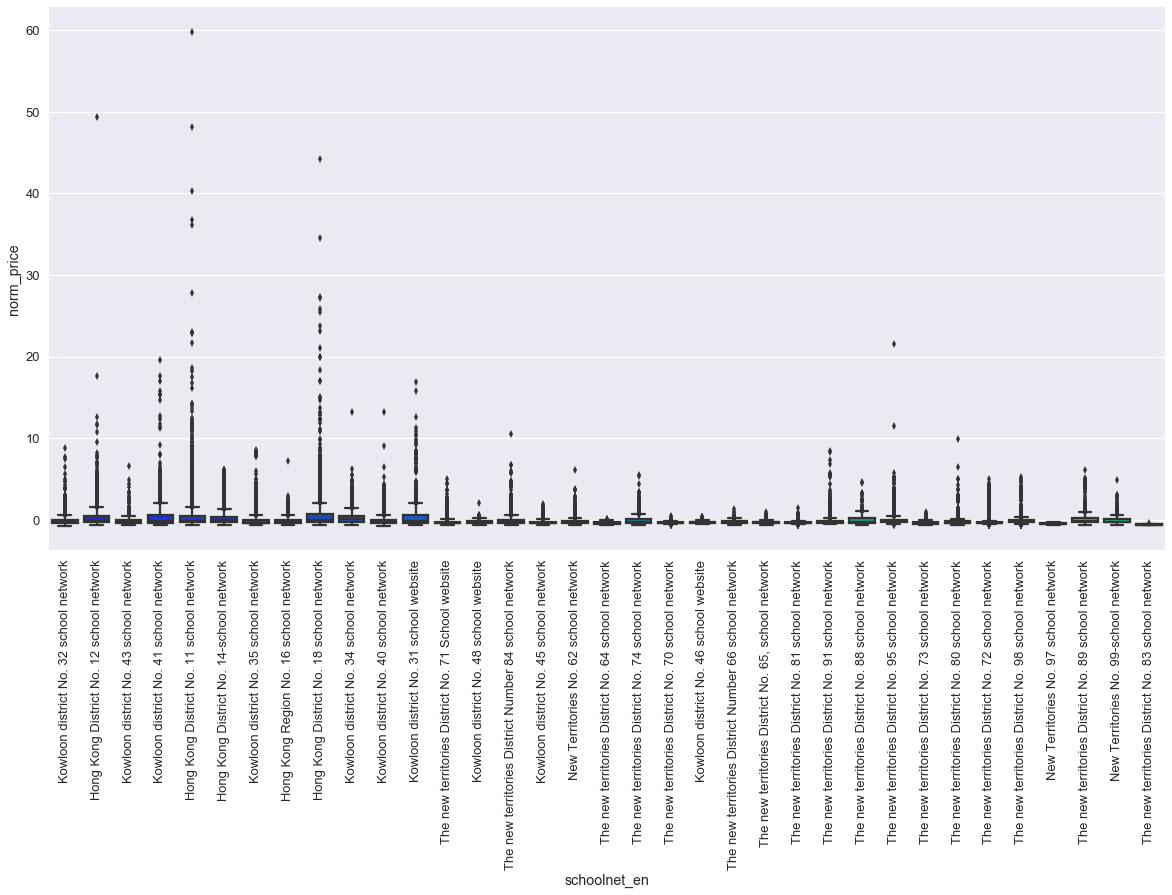

In [57]:
plt.figure(figsize = (20,10))
bplot = sns.boxplot(y ='norm_price', x = 'schoolnet_en', data = df_new, palette = 'winter')
for label in bplot.get_xticklabels():
    label.set_rotation(90)

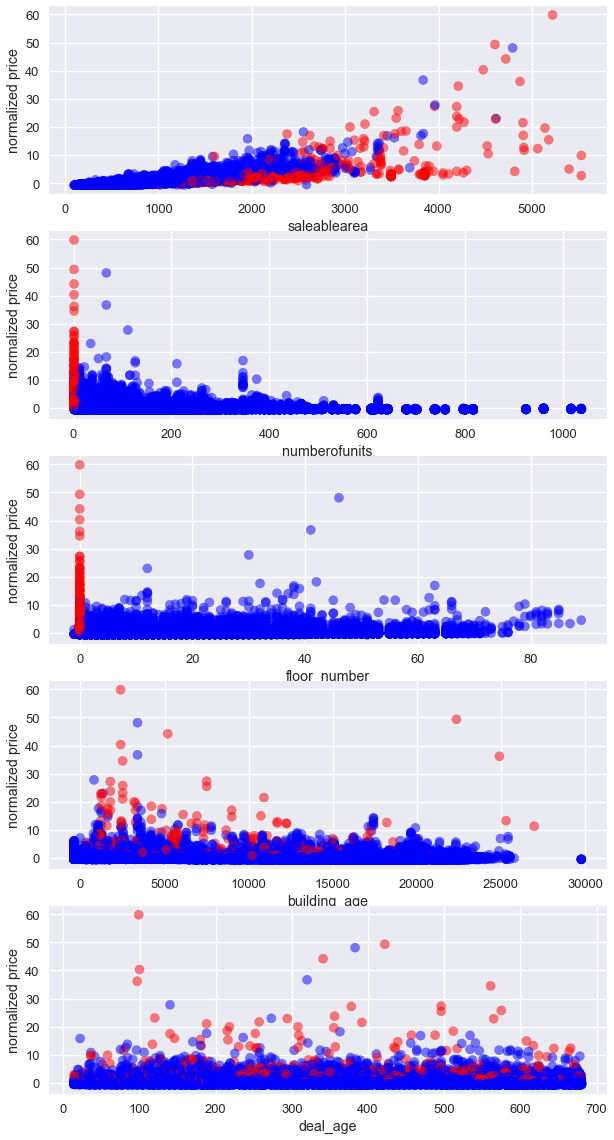

In [76]:
l_scatter = [
    'saleablearea', 'numberofunits', 'floor_number', 
    'building_age', 'deal_age'
]
color_dict = { 0 : 'blue', 1 : 'red'}

fig, axe = plt.subplots( len( l_scatter ), 1, figsize = (10,20))
for i, col in enumerate( l_scatter ):
    axe[i].scatter(x = df_new[col], 
                   y = df_new['norm_price'], 
                   c = df_new['is_dettached'].apply(lambda x : color_dict[x]), 
                    alpha = 0.5
                )
    axe[i].set_ylabel('normalized price')
    axe[i].set_xlabel(col)

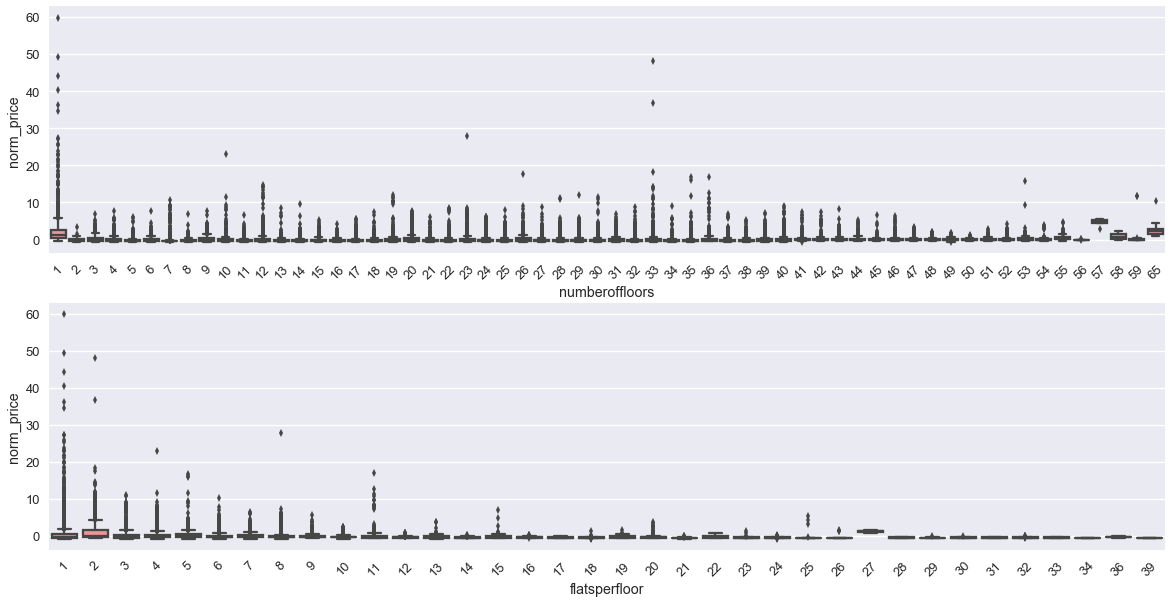

In [75]:
l_box = ['numberoffloors', 'flatsperfloor']

fig, axe = plt.subplots( len( l_box ), 1, figsize = (20,10))
for i, col in enumerate( l_box ):
    iplot = sns.boxplot( x = col , y = 'norm_price',
                       data = df_new ,
                       ax = axe[i]
                        )
    for label in iplot.get_xticklabels():
        label.set_rotation(45)

## Findings
* `price` even when normalized into `norm_price` is **not** normally distributed.
    * it is supectible to `region`. Maybe a model should be built on regional data?
    * maybe we should remove outlines that are over 10 std dev?
* `schoolnet_en` seems like a valuable feature
* the new feature `is_dettached` proves to be a major cause of outliners

### Useful References:
https://api.portal.hkmapservice.gov.hk/
http://www1.map.gov.hk/gih3/view/index.jsp
https://www.28hse.com/utf8/schoolnetwork_c11-P2.html